<h2>Step 1: Import the libraries needed for the code.</h2>
<p>Import all the needed libraries after you have installed them in the virtual environment.</p>

In [1]:
# First we import the required libraries
import tensorflow as tf
import random
import numpy as np
import pandas as pd
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import io
import requests
import re

#sklearn actually refers to scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K 
K.clear_session()

# Check tensorflow version
if float(tf.__version__[0]) < 2.0:
  print('Updating tensorflow')
  !pip install tensorflow==2.0
else:
  print('Correct version of Tensorflow installed.')

Correct version of Tensorflow installed.


<h2>Step 2: Get the data from the training set.</h2>
<p>The training dataset file that we're using is named 'train.csv'.</p>
<p>The training and test datasets were obtained from this  <a href="https://www.kaggle.com/c/fake-news/data">link</a>.</p>

In [2]:
# Retrieve the data from the training set
df = pd.read_csv('train.csv')
df = df.fillna(' ')
df.count()

id        20800
title     20800
author    20800
text      20800
label     20800
dtype: int64

## Step 3: Now we tokenize the words in the training set.
<p>The text will first be tokenized.</p>
<p>Following that, it is converted into sequence and then padded to give them a uniform length.</p>

In [3]:
# Tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text']) # This encodes all the values in the 'text' column of the dataframe
word_index = tokenizer.word_index #returns a dictionary of key value pairs where the key is the word in 
#the sentence and the value is the label assigned to it. Basically: the words and the values assigned to them
vocab_size=len(word_index) 

# Padding data
sequences = tokenizer.texts_to_sequences(df['text']) #converts the sentences to their labelled equivalent based 
#on the corpus of words passed to it
padded = pad_sequences(sequences, maxlen=500, padding='post', truncating='post') #makes the sentences uniform in length
#Here, the maximum length of the sentence is defined as 500, and the padding is to be done after the sentence instead of before.
#The padding makes each sentence as long as the longest sentence and. It's been set to pad and truncate/shorten at the end of the sentence.

## Step 4: Split the dataset into 2 parts.
Now the dataset is to be split into 2 parts: the training set and the test set

In [4]:
split = 0.2
split_n = int(round(len(padded)*(1-split),0))
#This gets the number of values in padded and times it

#The round function rounds a floating point number to the nearest specified amount of decimals. 
#The defualt arguement for to what decimal place is 0. At 0, it returns a full integer.

#Then it returns split_n as an integer value. This should be 80% of the original number of values

train_data = padded[:split_n] #This splits the overall data into the training data for 80% of it
train_labels = df['label'].values[:split_n] #This assigns the front 80% of the label to the variable
test_data = padded[split_n:] #This splits the overall data into the test data for 20% of it
test_labels = df['label'].values[split_n:] #This assigns the back 20% of the label to the variable

<h2>Step 5: Import the glove.6B.100d.txt file into the code.</h2> This file contains values for many words already inside, which we will be feeding to the machine learning code. All the values in the file is then put into an empty array, ignoring any empty values.

In [5]:
# Import tensor representations for words

embeddings_index = {};
with open('glove.6B.100d.txt', encoding="utf8") as f:  #So glove.6B.100d.txt is a file with Pre-trained word vectors, with
    #6 billion tokens and 100 features
    for line in f:
        values = line.split(); #This puts each line into a separate array for each and each word in each line as a separate 
        #value within each array
        word = values[0]; #this assigns the first word in each line to the variable. It is 0 since the word is the first value
        #in each line
        coefs = np.asarray(values[1:], dtype='float32'); # This assigns all the coefficients for the word in the line to this variable
        #The syntax of values should mean that the front part of the second value/first coeff onwards is returned.
        embeddings_index[word] = coefs; #This puts all the coefficients into the empty embeddings_index array earlier
#There are 100 coeffs for the words in the txt file.

embeddings_matrix = np.zeros((vocab_size+1, 100)); #np.zeros is a function that fills an empty array with zeros, up to the number you
#specify for it. The paremeter passed here is the shapes arguement, which defines the shape of the array. Here, it is defined as vocab_size+1
#rows by 100 columns. Reminder that here, vocab_size+1 is 238052, so there are 238052 rows by 100 columns. 100 columns, since there are
#100 features per row in glove.6B.100d.txt
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word); #The current value of the item in word_index is assigned to this variable.
    if embedding_vector is not None: #if the is a value assigned to embedding_vector 
        embeddings_matrix[i] = embedding_vector; #it gets put into the embeddings_matrix array
        #This should effectively weed out any empty values in the dataset and have a more proper dataset.

<h2>Step 6: Build the model.</h2>

In [6]:
# Build the architecture of the model
     
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 100, weights=[embeddings_matrix], trainable=False), #.embedding is used as the first layer of 
    #the model. The size of the vocabolary and number of dimensions are passed, and the weights are assigned here, which cannot be trained i think.
    tf.keras.layers.Dropout(0.2), #Dropout will randomly set input units to 0 with a rate to prevent overfitting. The arguement to be 
    #passed here is the rate: 0.2, which is 20%.
    tf.keras.layers.Conv1D(80, 5, activation='relu'), #Cropping layer for 1D
    tf.keras.layers.MaxPooling1D(pool_size=5), #the max size of the pooling window is 5 here.
    tf.keras.layers.LSTM(20, return_sequences=True), #Long Short-term Memory layer. LSTMs address the vanishing gradient problem that occurs 
    #when training RNNs. Return_sequences is used to decide whether to return the last output. in the output sequence, or the full sequence.
    tf.keras.layers.LSTM(20),
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(512), #Densely connected NN layer. The units parameter denotes the output size of the layer
    tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(1, activation='sigmoid') #activation arguement is what activation function to use 
])

<h2>Step 7: Put together the model and see its progress.</h2>

<p>I believe this is what the Adam optimizer consists of. <a href="https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam">Source</a>.</p>
<blockquote>
    tf.keras.optimizers.Adam(
        learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
        name='Adam', **kwargs
    )
</blockquote>

In [7]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy']) #binary_crossentropy computes the cross-entropy loss 
#between true labels and predicted labels. The optimizer uses the Adam alogorithm here. The class accuracy 
#calculates accuracy.
model.summary()

history = model.fit(train_data, train_labels, epochs=5, batch_size=100, validation_data=[test_data, test_labels])

print("Training Complete")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         23805200  
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 80)          40080     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 80)          0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 20)          8080      
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0

<h2>Step 8: Put together the model of the produced results.</h2>

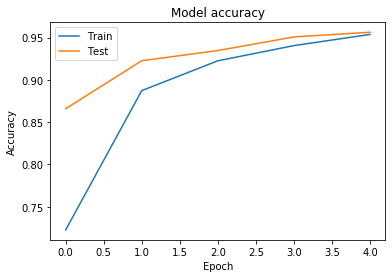

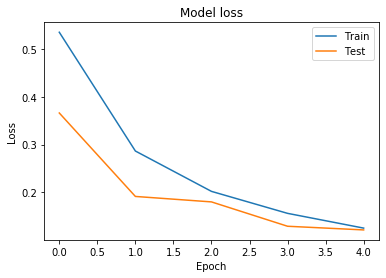

In [8]:
# Visualize the results:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

## Step 9: Include the code for extracting the text from the url here
<p>Now here is the code that will obtain the text from the news articles.</p>
<p>First, it checks if the inputed data is a valid url with 'check_url()', and the input is rejected if it fails the check.</p>
<p>It is then put through 'clean_article()', and returns the text if there were no other errors.</p>
<p><em>Note: The variables that are defined as various links at the start of the cell are no longer needed.</em> They are a holdover from when the user input function was not inplemented yet and the code was still in testing.</p>

In [9]:
def check_url(website_link):
    if len(website_link) > 0:   
        if (website_link[:4] == "http") & (len(website_link) > 7):
            return clean_article(website_link)
        else:
            return "Not a website"    
    else:
        return "input is empty"
        
def clean_article(website_link):
    website_html = requests.get(website_link).text.encode("utf-8").decode("windows-1252", "ignore")
    #print(website_html)
    if len(website_html) > 0:
        try:
            if len(re.findall("<p>.*?</p>", website_html)) > 0:
                article = re.findall("<p>.*?</p>", website_html)
            elif len(re.findall(r"(<p\s.*?>.*?<\/p>)", website_html, re.S)) > 0:
                article = re.findall(r"(<p\s.*?>.*?<\/p>)", website_html, re.S)
            elif len(re.findall("<p>.*", website_html)) > 0:
                article = re.findall("<p>.*", website_html)
            else:
                return(website_html)

            article = '\n'.join([str(i) for i in article])
            cleanr = re.compile('<.*?>')
            article = re.sub(cleanr, '', article) 
            return article
        except UnicodeEncodeError:
            return "Article is not suitable for python to read"
    else:
        return "Article unable to load"


## Step 10: Format the inputed data so that it can be used to make a prediction
<p>Here, the user will have to input in a url, and the the code checks if it can be used.</p>
<p>Now the text that was obtained is put into a data frame, tokenized and padded, similar to how the training data was formatted.</p>
<p>The Model will now predict the likelihood of the article being unreliable using the trained model. The output is rounded to 5 decimal places.</p>
<p>And thus, the code can predict how likely a news article is unreliable.</p>

In [ ]:
status = 0
while status == 0:
    print("Please input a link to a news article.")
    hold_input = input()
    user_url_input = check_url(hold_input)
    try:
        if hold_input == "cancel":
            print("The program will stop now")
            status = 1
        elif user_url_input == "Not a website" or user_url_input == "input is empty" or user_url_input == "Article is not suitable for python to read" or user_url_input == "Article unable to load":
            print("This input is not suitable.")
            print("Reason: " + user_url_input)
        else:
            #So we put the text that was pulled from the site and put it into an array
            input_array = np.array([[0, 'random title', 'random writer', user_url_input]])
            column_name = ['id', 'title', 'author', 'text']
            input_dataframe = pd.DataFrame(data=input_array, columns=column_name) #Then it's formatted into a dataframe

            #Similar to when the training data was being formatted, we will tokenize the text in the 'text' field, followed by padding.
            tokenizer.fit_on_texts(input_dataframe['text'])
            input_sequences = tokenizer.texts_to_sequences(input_dataframe['text'])
            input_padded = pad_sequences(input_sequences, maxlen=500, padding='post', truncating='post')

            #Now the input data is now formatted similarly to the training data, and is now passed to the model.predict() function.
            prediction = model.predict(input_padded) 
            rounded_prediction = round(prediction[0,0]*100, 5)
            output_prediction = "This is the model's predicted value: {}%".format(rounded_prediction)
            print(output_prediction)

            reliability = 100-rounded_prediction
            output_reliability = "This is the model's prediction of how accurate the article provided is: {}%".format(reliability)
            print(output_reliability)    

            if rounded_prediction <= 30:
                print("This article is reliable")
            elif rounded_prediction > 30 and rounded_prediction <= 50:
                print("This article is likely reliable")
            elif rounded_prediction > 50 and rounded_prediction <= 70:
                print("This article is likely unreliable")
            else:
                print("This article is garbage, trash, and not even worthy of a 3rd adjective. Where did you even find this?")
    except:
        input_array = np.array([[0, 'random title', 'random writer', user_url_input]])
        column_name = ['id', 'title', 'author', 'text']
        input_dataframe = pd.DataFrame(data=input_array, columns=column_name) 

        tokenizer.fit_on_texts(input_dataframe['text'])
        input_sequences = tokenizer.texts_to_sequences(input_dataframe['text'])
        input_padded = pad_sequences(input_sequences, maxlen=500, padding='post', truncating='post')

        prediction = model.predict(input_padded) 
        rounded_prediction = round(prediction[0,0]*100, 5)
        output_prediction = "This is the model's predicted value: {}%".format(rounded_prediction)
        print(output_prediction)

        reliability = 100-rounded_prediction
        output_reliability = "This is the model's prediction of how accurate the article provided is: {}%".format(reliability)
        print(output_reliability)    

        if rounded_prediction <= 30:
            print("This article is reliable")
        elif rounded_prediction > 30 and rounded_prediction <= 50:
            print("This article is likely reliable")
        elif rounded_prediction > 50 and rounded_prediction <= 70:
            print("This article is likely unreliable")
        else:
            print("This article is unreliable")
        
print("It has been stopped.")

Please input a link to a news article.


 https://www.theonion.com/immune-system-bored-too-1843269164


This is the model's predicted value: 99.62586%
This is the model's prediction of how accurate the article provided is: 0.37413999999999703%
This article is unreliable
Please input a link to a news article.
